In [1]:
from neuron import h, gui   # Standard "import" of the NEURON library into Python...
import matplotlib.pyplot as plt
import statistics 
import numpy as np
import seaborn as sns
h.load_file('stdrun.hoc')   # Activation of a NEURON library, to fine control the simulation...

1.0

### Light model

In [2]:
from numpy import arcsin
from math import pi
from numpy import sqrt,sinh,cosh,exp

class I():
    
    def __init__(self,I_0):
        self.I_0=I_0        # source light irradiancecenter of fiber optic output          
        self.n = 1.36        # index of refraction of gray matter
        self.NA = 0.37        # numerical aperture of the optical fiber
        self.theta_div = arcsin(self.NA/self.n)  # divergence half-angle 
        self.R_0 = 0.1      #Optical fiber radius [mm]
        self.K = 0.1249     # coefficients for absorbance (1/mm) Range: (0.05233, 0.1975)
        self.S = 7.37      # coefficients for scattering  (1/mm) # Range: (6.679, 8.062)
    
    def Light_irradiance(self,r,z):
        return self.I_0*self.Trasmittance(r,z)
    
    def Trasmittance(self,r,z):
        return self.Gaussian_distr(r,z)*self.apparent_radius(z)*self.Scattering_absorbance(r,z)

    def Gaussian_distr(self,r,z):
        return exp(-2*pow(r/self.apparent_radius(z),2))/sqrt(2*pi)
    
    def Conical_spreading(self,z):
        return pow(self.R_0/self.apparent_radius(z),2)
    
    def Scattering_absorbance(self,r,z):
        a=1+self.K/self.S
        b=sqrt(pow(a,2)-1)
        distance=sqrt(pow(r,2)+pow(z,2))
        den= (a * sinh(b * self.S * distance) + b * cosh(b * self.S * distance))
        return  b / den
    
    def apparent_radius(self,z):
            """ Find the apparent radius at a distance z
            """
            from numpy import tan
            return self.R_0 + z*tan(self.theta_div)

In [7]:
def root_section():
        return h.SectionRef().root
    
def build_tree(func= lambda sec:sec.v,segfunc=False):
        """ func must act on a neuron section
        """
        from numpy import array
        print("-"*100)
        def append_data(sec, xyzdv, parent_id, connections,func,segfunc):
            """ Append data to xyzdv
            """
            if not segfunc: v=func(sec)
            n = int(h.n3d(sec=sec))
            for ii in range(1, n):
                x = h.x3d(ii,sec=sec)
                y = h.y3d(ii,sec=sec)
                z = h.z3d(ii,sec=sec)
                d = h.diam3d(ii,sec=sec)
                if segfunc:
                    if n==1:v=func(sec(0.5))
                    else:v = func(sec(ii/float(n-1)))
                xyzdv.append([x,y,z,d,v])
                child_id = len(xyzdv)-1
                if len(xyzdv)>1:
                    connections.append([child_id, parent_id])
                parent_id = child_id
            return xyzdv, connections

        def append_children_data(parent, parent_id, xyzdv, connections, func, segfunc):
            sref = h.SectionRef(sec=parent)
            if sref.child:
                for child in sref.child:
                    xyzdv, connections = append_data(child, xyzdv, parent_id, connections, func, segfunc)
                    xyzdv, connections = append_children_data(parent = child,
                                                              parent_id = len(xyzdv)-1,
                                                              xyzdv = xyzdv,
                                                              connections = connections,
                                                              func = func,
                                                              segfunc = segfunc)
            return xyzdv, connections

        # Find data and connections
        root_sec = root_section()
        if segfunc:
            if root_sec.nseg==1:
                v = func(root_sec(0.5))
            else:
                v = func(root_sec(0.0))
        else:
            v=func(root_sec)
        h.finitialize()
        xyzdv = [[h.x3d(0,sec=root_sec),h.y3d(0,sec=root_sec),h.z3d(0,sec=root_sec),h.diam3d(0,sec=root_sec),v]]
        xyzdv, connections = append_data(root_sec, xyzdv, 0, [],func,segfunc)
        xyzdv, connections = append_children_data(root_sec,len(xyzdv)-1,xyzdv,connections,func,segfunc)
        xyzdv = array(xyzdv)
        connections = array(connections)
        
        return xyzdv,connections
        
def plot(scaling = 1, segfunc=False, clim=None,cmap=None):
        """ plot cell in matplotlib line plot collection
        """
        from numpy import array, linspace
        from matplotlib.collections import LineCollection
        from matplotlib import pyplot
        xyzdv,connections=build_tree()
        pts   = xyzdv[:,:2]
        edges = connections
        diam  = xyzdv[:,3]
        data  = xyzdv[:,4]
        print( "DATA RANGE: ",data.min(),data.max())
        # Define colors
        if not cmap:
            from matplotlib.cm import jet as cmap
        if not clim:
            clim=[data.min(),data.max()]
        a = (data - clim[0])/(clim[1]-clim[0])
        # Define line segments
        segments = []
        for edge in edges:
            segments.append([pts[edge[0],:], pts[edge[1],:]])
        # Build Line Collection
        collection = LineCollection(segments = array(segments),
                                    linewidths = diam*scaling,
                                    colors=cmap(a))
        collection.set_array(data)
        collection.set_clim(clim[0], clim[1])
        pyplot.gca().add_collection(collection,autolim=True)
        pyplot.axis('equal')
        return collection

----------------------------------------------------------------------------------------------------
DATA RANGE:  -65.0 -65.0


/Users/giulia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


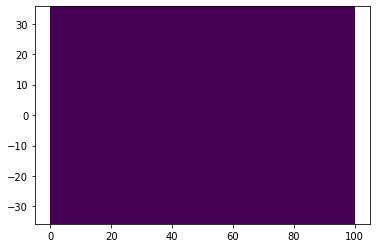

In [16]:
from matplotlib import pyplot
 
plot()

### Neuron model

In [2]:
soma = h.Section(name='soma')
soma.cm = 0.5
h.psection()

soma { nseg=1  L=100  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=0.5}
}


1.0

In [3]:
axon=h.Section(name='axon')
axon.nseg=100
axon.Ra=123
axon.L=200
axon.diam=2

In [4]:
for sec in h.allsec():
    sec.insert('WBCN')
    sec.insert('ChR2')
    print(sec)

soma
axon


In [8]:
tot=30000
n=0
freq=50
#intensity=I(520)
#freq=1000
for seg in soma:
    seg.ChR2.wavelength=470
    seg.ChR2.pulse_width=10
    seg.ChR2.light_delay=freq
    seg.ChR2.n=int(tot/seg.ChR2.light_delay)
    seg.ChR2.light_intensity=20
    #seg.ChR2.light_intensity=intensity.Light_irradiance(0,1)
    n=int(seg.ChR2.n)
    #seg.WBCN.NK*=0.1
    #seg.WBCN.NNa*=0.1

In [9]:
for seg in axon:
    seg.WBCN.NK*=0.1
    seg.WBCN.NNa*=0.1
    seg.ChR2.wavelength=470
    seg.ChR2.pulse_width=10
    seg.ChR2.light_delay=freq
    seg.ChR2.n=int(tot/seg.ChR2.light_delay)
    seg.ChR2.light_intensity=20
    
axon(0.005).WBCN.NNa*=100
axon(0.005).WBCN.NK*=100

In [10]:
#axon.connect(soma,1)
h.topology()
h.psection()


|-|       soma(0-1)
|----------------------------------------------------------------------------------------------------|       axon(0-1)

soma { nseg=1  L=100  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=0.5}
	insert WBCN { se_WBCN=-1 gnabar_WBCN=0.08 gkbar_WBCN=0.036 gl_WBCN=0.0003 el_WBCN=-54.3 NNa_WBCN=6000 NK_WBCN=1800}
	insert na_ion { ena=50}
	insert k_ion { ek=-77}
	insert ChR2 { n_ChR2=600 gmax_ChR2=0.4 light_delay_ChR2=50 pulse_width_ChR2=10 light_intensity_ChR2=20 Irradiance_ChR2=0 wavelength_ChR2=470}
}


1.0

### Recording parameters & simulation

In [ ]:
h.dt=0.01
v_vec = h.Vector()             # Membrane potential vector is created here
t_vec = h.Vector()             # Time stamp vector is created here
'''
m_som = h.Vector()             # Open Na gate variable vector is created here
h_som = h.Vector()             # Inactivation gate variable vector is created here
n_som = h.Vector()             # Open K gate variable vector is created here
O1_som=h.Vector()
O2_som=h.Vector()
C1_som=h.Vector()
'''
v_vec_AIS = h.Vector()             # Membrane potential vector is created here
v_vec_axEnd = h.Vector() 
v_vec_ax1 = h.Vector() 
v_vec_ax2 = h.Vector() 
v_vec_ax3 = h.Vector() 
v_vec_ax4 = h.Vector() 

'''
m_som.record(soma(0.5).WBCN._ref_m) # The appropriate state-variable is linked to the vector
h_som.record(soma(0.5).WBCN._ref_h) # The appropriate state-variable is linked to the vector
n_som.record(soma(0.5).WBCN._ref_n) # The appropriate state-variable is linked to the vector
O1_som.record(soma(0.5).ChR2._ref_O1) # The appropriate state-variable is linked to the vector
O2_som.record(soma(0.5).ChR2._ref_O2) # The appropriate state-variable is linked to the vector
C1_som.record(soma(0.5).ChR2._ref_C1) # The appropriate state-variable is linked to the vector
'''

v_vec.record(soma(0.5)._ref_v) # The voltage of the soma section is linked to the vector v_vec
t_vec.record(h._ref_t)         # The absolute time of the simulation is linked to the vector t_vec
v_vec_AIS.record(axon(0.005)._ref_v)
v_vec_ax1.record(axon(0.20500000000000004)._ref_v)
v_vec_ax2.record(axon(0.4050000000000002)._ref_v)
v_vec_ax3.record(axon(0.6050000000000003)._ref_v)
v_vec_ax4.record(axon(0.8050000000000005)._ref_v)
v_vec_axEnd.record(axon(0.9950000000000007)._ref_v)
h.v_init = -60                # Let's set the initial condition of the membrane potential

h.t     =   0.0               # Let's reset the initial time of the simulation to 0 ms
h.tstop = float(tot)
h.run()

violet = 400 nm

indigo = 470 nm

blu =  510 nm

verde = 540 nm

giallo = 580 nm

arancione = 600 nm

rosso = 700 nm

### Plot Results Soma

In [ ]:
plt.plot(t_vec, v_vec,label="soma",color="orange")
plt.plot(t_vec, v_vec_AIS,label="AIS",color="lightgreen")
plt.plot(t_vec, v_vec_axEnd,label="axon end",color="pink")
plt.xlabel('time (ms)')
plt.title('Delay record along the axon')
plt.ylabel('Voltage (mV)')
plt.legend(loc="upper right")
plt.xlim(1.3,4)
#plt.savefig("graphs/light/soma_axon/Uniform_light/voltage_delay.png",bbox_inches='tight')

In [119]:
light_delay=freq
pulse_width=10
In=[]
for t in t_vec:
    aux=0.
    for i in range(0,n,1):
        if ( t >= (light_delay*i) and t <=(light_delay*i + pulse_width) ):
            aux=20.
    In.append(aux)
    

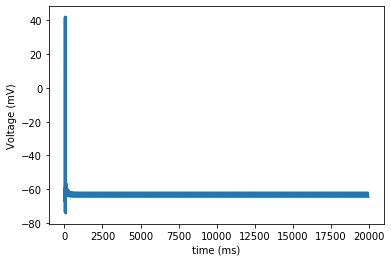

In [32]:
plt.plot(t_vec, v_vec)
#plt.plot(t_vec, In)
plt.xlabel('time (ms)')
#plt.title('Neuron optogenetic,soma response,I=20 mW/mm^2,f=20 Hz')
plt.ylabel('Voltage (mV)')
#plt.xlim(0,1000)
#plt.legend(('out (mV)', 'In (mW/mm^2)'),loc="upper right")
#plt.savefig("graphs/light/soma_axon/voltage_soma.png",bbox_inches='tight')
plt.show()

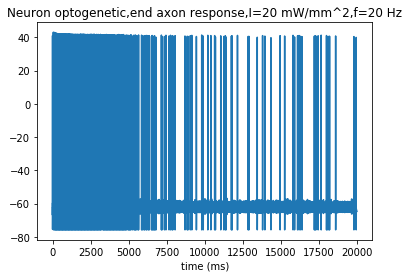

In [30]:
plt.plot(t_vec, v_vec_axEnd)
#plt.plot(t_vec, In)
plt.xlabel('time (ms)')
plt.title('Neuron optogenetic,end axon response,I=20 mW/mm^2,f=20 Hz')
#plt.ylabel('Voltage (mV)')
#plt.xlim(0,1000)
#plt.legend(('out (mV)', 'In (mW/mm^2)'),loc="upper right")
#plt.savefig("graphs/light/soma_axon/voltage_End.png",bbox_inches='tight')
plt.show()

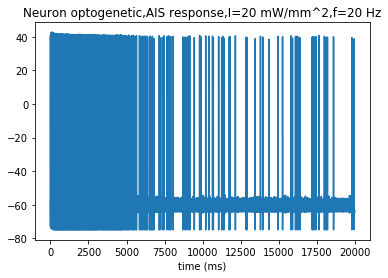

In [31]:
plt.plot(t_vec, v_vec_AIS)
#plt.plot(t_vec, In)
plt.xlabel('time (ms)')
plt.title('Neuron optogenetic,AIS response,I=20 mW/mm^2,f=20 Hz')
#plt.ylabel('Voltage (mV)')
#plt.xlim(0,1000)
#plt.legend(('out (mV)', 'In (mW/mm^2)'),loc="upper right")
#plt.savefig("graphs/light/soma_axon/voltage_AIS.png",bbox_inches='tight')
plt.show()

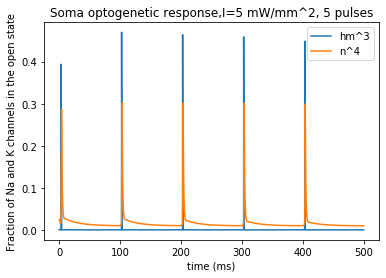

In [12]:
plt.plot(t_vec, m_som * m_som * m_som * h_som , t_vec, n_som * n_som * n_som * n_som)
#plt.plot(t_vec, m_AIS * m_AIS * m_AIS * h_AIS , t_vec, n_AIS * n_AIS * n_AIS * n_AIS)
plt.xlabel('time (ms)')
plt.title('Soma optogenetic response,I=5 mW/mm^2, 5 pulses')
plt.ylabel('Fraction of Na and K channels in the open state')
plt.legend(('hm^3', 'n^4'),loc="best")
#plt.xlim(0,100)
#plt.show()
plt.savefig("graphs/light/soma/frac_channel_soma.png",bbox_inches='tight')

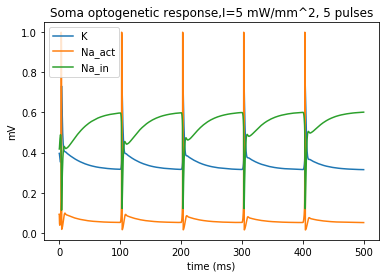

In [13]:
plt.plot(t_vec, n_som)
plt.plot(t_vec, m_som)
plt.plot(t_vec, h_som)
plt.xlabel('time (ms)')
plt.ylabel('mV')
plt.title('Soma optogenetic response,I=5 mW/mm^2, 5 pulses')
plt.legend(('K', 'Na_act', 'Na_in'))
#plt.xlim(0,100)
#plt.show()
plt.savefig("graphs/light/soma/channel_soma.png",bbox_inches='tight')

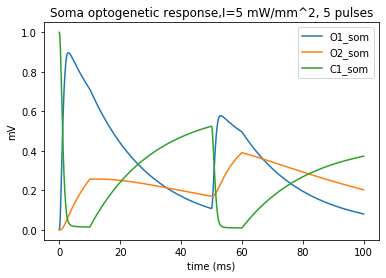

In [98]:
plt.plot(t_vec, O1_som)
plt.plot(t_vec, O2_som)
plt.plot(t_vec, C1_som)
plt.xlabel('time (ms)')
plt.ylabel('mV')
plt.title('Soma optogenetic response,I=5 mW/mm^2, 5 pulses')
plt.legend(('O1_som', 'O2_som', 'C1_som'))
#plt.xlim(0,100)
#plt.show()
#plt.savefig("graphs/light/soma/channel_soma.png",bbox_inches='tight')

### Latency

In [14]:
def Latency(v_vec,t_vec,n,freq):
    v=np.array(v_vec).tolist()
    t=np.array(t_vec)
    t1=t.tolist()
    t_out=[]
    lat=[]
    t_lat=[]
    for i in range(0,n):
        indx1=np.where(t > i*freq)[0][0]
        indx2=np.where(t <(i*freq+freq))[0][-1]
        aux=max(v[indx1:indx2])
        if(aux>5):
            aux_t=int(t1[v.index(aux)]/freq)*freq
            lat.append(t1[v.index(aux)]-aux_t)
            t_lat.append(aux_t/1000)
    return lat,t_lat

In [32]:
#lat_red,t_lat_red=Latency(v_vec,t_vec,n,freq)
lat_soma,t_lat_soma=Latency(v_vec,t_vec,n,freq)
lat_AIS,t_lat_AIS=Latency(v_vec_AIS,t_vec,n,freq)
lat_ax1,t_lat_ax1=Latency(v_vec_axEnd,t_vec,n,freq)

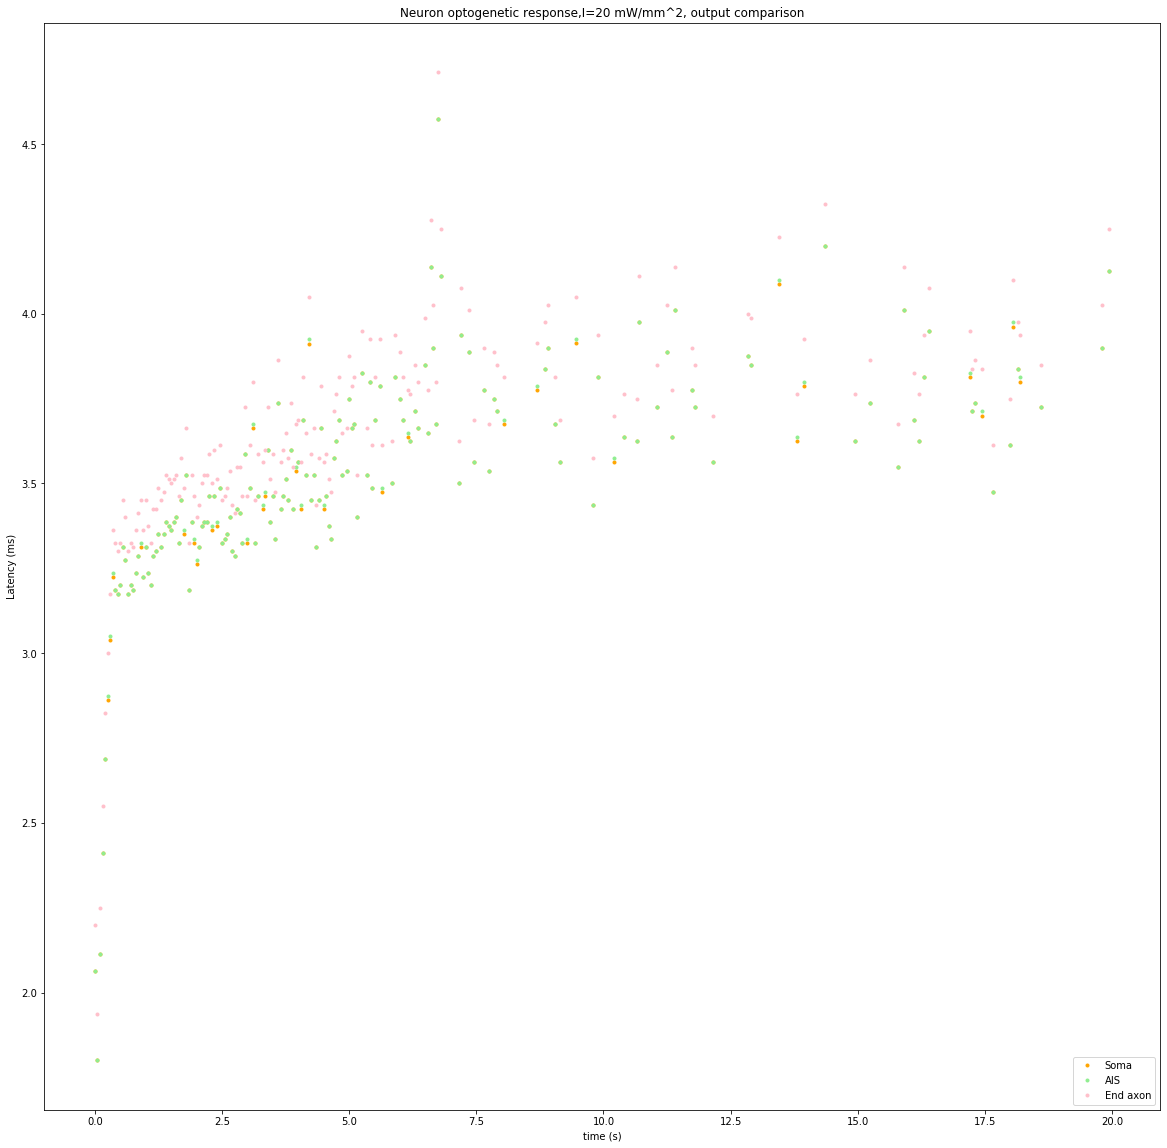

In [33]:
plt.figure(figsize=(20,20))
plt.plot(t_lat_soma, lat_soma, '.', color='orange', label="Soma")
plt.plot(t_lat_AIS, lat_AIS, '.', color='lightgreen', label="AIS")
plt.plot(t_lat_ax1, lat_ax1, '.', color='pink', label="End axon")
#plt.plot(t_lat_vio, lat_vio, '.', color='#EE82EE', label="400 nm")
#plt.plot(t_lat_indago, lat_indago, '.', color='#4b0082', label="470 nm")
#plt.plot(t_lat_blu, lat_blu, '.', color='blue', label="510 nm")
#plt.plot(t_lat_gree, lat_gree, '.', color='green', label="540 nm")
#plt.plot(t_lat_y, lat_y, '.', color='yellow', label="580 nm")
#plt.plot(t_lat_orange, lat_orange, '.', color='orange', label="600 nm")
#plt.plot(t_lat_50, lat_50, '.', color='aquamarine', label="20 Hz")
#plt.plot(t_lat_45, lat_45, '.', color='lightgreen', label="22 Hz")
#plt.plot(t_lat_red, lat_red, '.', color='red', label="700 nm")
#plt.plot(t_lat_37, lat_37, '.', color='#981f2d', label="27 Hz")
#plt.plot(t_lat_35, lat_35, '.', color='#5ec5a8', label="30 Hz")
#plt.plot(t_lat_30, lat_30, '.', color='#8c5ec5', label="33 Hz")
plt.xlabel('time (s)')
plt.ylabel('Latency (ms)')
plt.title('Neuron optogenetic response,I=20 mW/mm^2, output comparison')
plt.legend(loc="lower right")
#plt.xlim(0,10)
#plt.savefig("graphs/light/soma_axon/Uniform_light/Latency_com.png")

#### Nspike

In [17]:
def Count(v_vec):
    count=0
    #Npeak=[]
    Na=0
    for i in range(0,len(v_vec)):
        #Npeak.append(0)
        if(count==0 and v_vec[i]>=-10.):
            count=1
            Na+=1;
            #Npeak.append(1)
        if(count==1 and v_vec[i]<-10.):
            count=0
            #Npeak.append(0)
    return Na


def Nspike(v_vec,t_vec,n,freq):
    v=np.array(v_vec).tolist()
    t=np.array(t_vec)
    t1=t.tolist()
    N_out=[]
    for i in range(0,n):
        indx1=np.where(t >= i*freq)[0][0]
        indx2=np.where(t <(i*freq+freq))[0][-1]
        aux=v[indx1:indx2]
        N_out.append(Count(aux))
    t_out=[i for i in range(0,n)]
    return N_out,t_out

In [56]:
#N_vio,Nt_vio=Nspike(v_vec,t_vec,30,1000)
#N_ind,Nt_ind=Nspike(v_vec,t_vec,30,1000)
#N_blu,Nt_blu=Nspike(v_vec,t_vec,30,1000)
#N_gre,Nt_gre=Nspike(v_vec,t_vec,30,1000)
#N_y,Nt_y=Nspike(v_vec,t_vec,30,1000)
#N_or,Nt_or=Nspike(v_vec,t_vec,30,1000)
N_red,Nt_red=Nspike(v_vec,t_vec,30,1000)

In [34]:
N_soma,t_soma=Nspike(v_vec,t_vec,9,1000)
N_AIS,t_AIS=Nspike(v_vec_AIS,t_vec,9,1000)
N_ax1,t_ax1=Nspike(v_vec_axEnd,t_vec,9,1000)

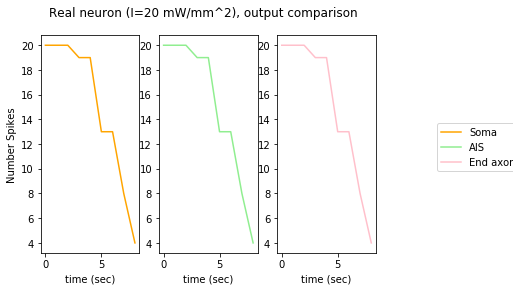

In [35]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3)
ax1.plot(t_soma,N_soma,color='orange',label = "Soma")
ax2.plot(t_AIS,N_AIS,color='lightgreen',label = "AIS")
ax3.plot(t_ax1,N_ax1,color='pink',label = "End axon")
ax1.set_ylabel("Number Spikes")
ax1.set_xlabel("time (sec)")
ax2.set_xlabel("time (sec)")
ax3.set_xlabel("time (sec)")
fig.suptitle("Real neuron (I=20 mW/mm^2), output comparison")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

'''
plt.plot(Nt_vio, N_vio, color='#EE82EE', label="400 nm")
plt.plot(Nt_ind, N_ind, color='#4b0082', label="470 nm")
plt.plot(Nt_blu, N_blu, color='blue', label="510 nm")
plt.plot(Nt_gre, N_gre, color='green', label="540 nm")
plt.plot(Nt_y, N_y, color='yellow', label="580 nm")
plt.plot(Nt_or, N_or, color='orange', label="600 nm")
plt.plot(Nt_red, N_red, color='red', label="700 nm")
'''
#plt.plot(N_Spike_40.s, N_Spike_40.N,color='yellow')
#plt.axvline(x=20, color='k', linestyle='--')
#plt.xticks(rotation=45)
#plt.legend(["soma","AIS","axon(0.2)","axon(0.4)","axon(0.5)","axon(0.6)","axon(0.8)","end axon"])
#plt.title("Real soma(I=20 mW/mm^2), wavelight comparison")
#plt.ylabel("Number Spikes")
#plt.xlabel("time (sec)")
#plt.savefig("graphs/light/soma_axon/Uniform_light/Nspike_out_com.png",bbox_inches = "tight")
plt.show()

#### peak intensity

In [20]:
def Intensity(v_vec,t_vec,n,freq):
    v=np.array(v_vec).tolist()
    t=np.array(t_vec)
    t1=t.tolist()
    t_out=[]
    intens=[]
    t_p=[]
    for i in range(0,n):
        indx1=np.where(t > i*freq)[0][0]
        indx2=np.where(t <(i*freq+freq))[0][-1]
        aux=max(v[indx1:indx2])
        aux_t=int(t1[v.index(aux)]/freq)*freq
        intens.append(aux)
        t_p.append(aux_t/1000)
    return intens,t_p

In [155]:
#int_vio,t_int_vio=Intensity(v_vec,t_vec,n,freq)
#int_ind,t_int_ind=Intensity(v_vec,t_vec,n,freq)
#int_blu,t_int_blu=Intensity(v_vec,t_vec,n,freq)
#int_gree,t_int_gree=Intensity(v_vec,t_vec,n,freq)
#int_y,t_int_y=Intensity(v_vec,t_vec,n,freq)
#int_orange,t_int_orange=Intensity(v_vec,t_vec,n,freq)
int_red,t_int_red=Intensity(v_vec,t_vec,n,freq)

In [36]:
int_soma,t_int_soma=Intensity(v_vec,t_vec,n,freq)
int_AIS,t_int_AIS=Intensity(v_vec_AIS,t_vec,n,freq)
int_ax,t_int_ax=Intensity(v_vec_axEnd,t_vec,n,freq)

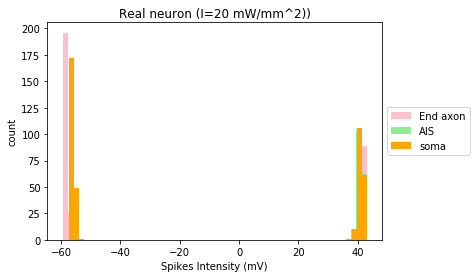

In [37]:
'''
fig, ((ax1,ax2),(ax3,x4)) = plt.subplots(2,2)
ax1.hist(int_soma, bins=60,color = 'aquamarine',label = "soma")
ax2.hist(int_AIS, bins=60,color = 'lightgreen',label = "AIS")
ax3.hist(int_ax, bins=60,color = 'red',label = "End axon")

plt.hist(int_ax2,bins=60,color = 'yellow',label = "axon (.4)")
plt.hist(int_axM,bins=60,color = 'black',label = "axon (.5)")
plt.hist(int_ax3,bins=60,color = 'green',label = "axon (.6)")
plt.hist(int_ax4,bins=60,color = 'blue',label = "axon (.8)")
plt.hist(int_ax,bins=60,color = 'pink',label = "end axon")
'''
plt.hist(int_ax, bins=60,color = 'pink',label = "End axon")
plt.hist(int_AIS, bins=60,color = 'lightgreen',label = "AIS")
plt.hist(int_soma, bins=60,color = 'orange',label = "soma")

#plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Real neuron (I=20 mW/mm^2))")
plt.ylabel("count")
plt.xlabel("Spikes Intensity (mV)")
#plt.ylim([0,90])
#plt.xlim([0,45])
#plt.savefig("graphs/light/soma_axon/Uniform_light/hist_Int_spike.png",bbox_inches = "tight")
plt.show()

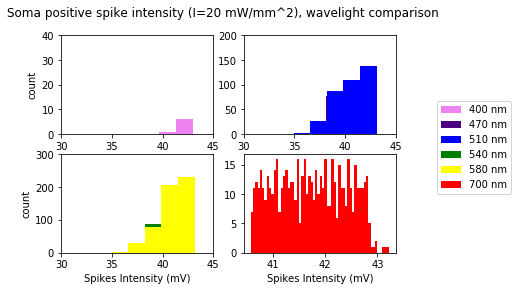

In [174]:
fig, ((ax1,ax2),(ax4,ax5)) = plt.subplots(2,2)
ax1.hist(int_vio, bins=60,color='#EE82EE', label="400 nm")
ax1.set(ylabel='count')
ax4.set(ylabel='count')
ax2.hist(int_ind, bins=60, color='#4b0082', label="470 nm")
ax4.set(xlabel="Spikes Intensity (mV)")
ax5.set(xlabel="Spikes Intensity (mV)")
ax2.hist(int_blu, bins=60,color='blue', label="510 nm")
ax4.hist(int_gree,bins=60,color='green', label="540 nm")
ax4.hist(int_y,bins=60,color='yellow', label="580 nm")
#ax5.hist(int_orange,bins=60,color='orange', label="600 nm")
ax5.hist(int_red,bins=60, color='red', label="700 nm")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle("Soma positive spike intensity (I=20 mW/mm^2), wavelight comparison")
ax1.set_xlim([30,45])
ax1.set_ylim([0,40])
ax2.set_xlim([30,45])
ax2.set_ylim([0,200])
ax4.set_xlim([30,45])
ax4.set_ylim([0,300])
#ax5.set_xlim([30,45])
#ax5.set_ylim([0,300])
#plt.xticks(rotation=45)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#lt.title("Real soma+axon (I=0.65 uA, Middle axon input)")
#plt.ylabel("count")
#plt.xlabel("Spikes Intensity (mV)")
#plt.ylim([0,10])
#plt.xlim([30,45])
#plt.savefig("graphs/light/soma/hist_Int_light_com_zoom.png",bbox_inches = "tight")
plt.show()

#### ISI

In [23]:
def Spike_time(v_vec,t_vec,n,freq):
    v=np.array(v_vec).tolist()
    t=np.array(t_vec)
    t1=t.tolist()
    t_out=[]
    for i in range(0,n):
        indx1=np.where(t > i*freq)[0][0]
        indx2=np.where(t <(i*freq+freq))[0][-1]
        aux=max(v[indx1:indx2])
        if(aux>5):
            t_out.append(t1[v.index(aux)])
    return t_out

def ISI(v_vec,t_vec,n,freq):
    t_spike=Spike_time(v_vec,t_vec,n,freq)
    isi=[]
    for i in range(len(t_spike)-1,0,-1):
        isi.append(t_spike[i]-t_spike[i-1])
    isi.reverse()
    return isi

In [176]:
'''
isi_soma=ISI(v_vec,t_vec,n,freq)
isi_AIS=ISI(v_vec_AIS,t_vec,n,freq)
isi_ax=ISI(v_vec_ax,t_vec,n,freq)
isi_ax1=ISI(v_vec_ax1,t_vec,n,freq)
isi_ax2=ISI(v_vec_ax2,t_vec,n,freq)
isi_axM=ISI(v_vec_axMiddle,t_vec,n,freq)
'''
#isi_vio=ISI(v_vec,t_vec,n,freq)
#isi_ind=ISI(v_vec,t_vec,n,freq)
#isi_blu=ISI(v_vec,t_vec,n,freq)
#isi_gree=ISI(v_vec,t_vec,n,freq)
#isi_y=ISI(v_vec,t_vec,n,freq)
#isi_orange=ISI(v_vec,t_vec,n,freq)
isi_ax_red=ISI(v_vec,t_vec,n,freq)

In [38]:
isi_soma=ISI(v_vec,t_vec,n,freq)
isi_AIS=ISI(v_vec_AIS,t_vec,n,freq)
isi_ax=ISI(v_vec_axEnd,t_vec,n,freq)

Text(0.5, 0.98, 'Neuron ISI (I=20 mW/mm^2), output comparison')

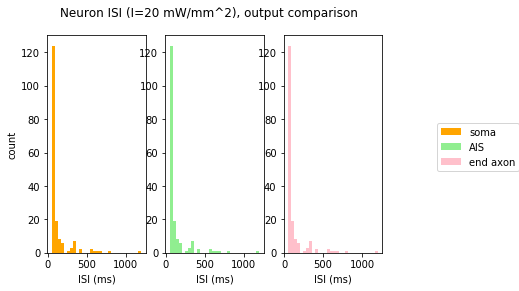

In [39]:
fig, ((s,ax2,ax4)) = plt.subplots(1,3)
s.hist(isi_soma, bins=30,color = 'orange',label = "soma")
ax2.hist(isi_AIS, bins=30,color = 'lightgreen',label = "AIS")
ax4.hist(isi_ax,bins=30,color = 'pink',label = "end axon")
s.set(ylabel='count')
ax4.set(xlabel="ISI (ms)")
ax2.set(xlabel="ISI (ms)")
s.set(xlabel="ISI (ms)")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle("Neuron ISI (I=20 mW/mm^2), output comparison")
#plt.savefig("graphs/light/soma_axon/Uniform_light/ISI_com.png",bbox_inches = "tight")

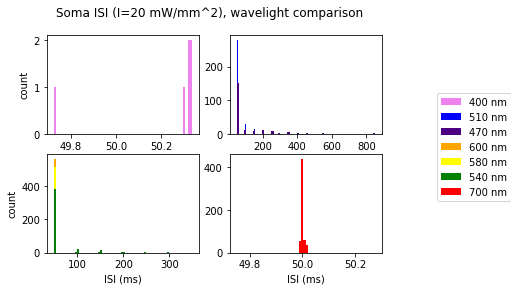

In [194]:
fig, ((ax1,ax2),(ax4,ax5)) = plt.subplots(2,2)
ax1.hist(isi_vio, bins=60,color='#EE82EE', label="400 nm")
ax1.set(ylabel='count')
ax4.set(ylabel='count')
ax4.set(xlabel="ISI (ms)")
ax5.set(xlabel="ISI (ms)")
ax2.hist(isi_blu, bins=60,color='blue', label="510 nm")
ax2.hist(isi_ind, bins=60, color='#4b0082', label="470 nm")
ax4.hist(isi_orange,bins=60,color='orange', label="600 nm")
ax4.hist(isi_y,bins=60,color='yellow', label="580 nm")
ax4.hist(isi_gree,bins=60,color='green', label="540 nm")
ax5.hist(isi_ax_red,bins=60, color='red', label="700 nm")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle("Soma ISI (I=20 mW/mm^2), wavelight comparison")

plt.savefig("graphs/light/soma/ISI_light_com.png",bbox_inches = "tight")